In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import patsy

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from pysal.model import mgwr
from mgwr.sel_bw import Sel_BW

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [3]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}
import math
from geopandas import GeoDataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
import mcdm

In [4]:
##node1 bus stop count
fs_area=gpd.read_file('metro_data/佛山/fs_area.shp',encoding="utf-8")
fs_station=gpd.read_file('metro_data/佛山/fs_station.shp',encoding="utf-8")

In [5]:
fs_station.rename(columns={'sid':'id','station_na':'station_name'},inplace=True)

In [6]:
fs_area = pd.merge(fs_area, fs_station, on='id',how='left')

In [7]:
fs_area=fs_area.drop(['geometry_y'],axis=1)
fs_area.rename(columns={'geometry_x':'geometry'},inplace=True)

In [8]:
fs_bus_station=gpd.read_file('metro_data/佛山/amap_bus_stops_fs.shp',encoding="utf-8")

In [9]:
fs_bus_station_count = gpd.sjoin(fs_bus_station, fs_area, how='right')
fs_bus_station_count_test = fs_bus_station_count.groupby(['id'])['stop_id'].agg(busStop_Count='count').reset_index() 

In [10]:
fs_area = pd.merge(fs_area, fs_bus_station_count_test, on='id',how='left')

In [11]:
#service time
fs_line=gpd.read_file('metro_data/佛山/line.shp',encoding="utf-8")
fs_station_raw=gpd.read_file('metro_data/佛山/station.shp',encoding="utf-8")

In [12]:
fs_line

,line_name,start_time,end_time,start_stop,end_stop,distance,basic_pric,total_pric,geometry
0,广佛线(沥滘--新城东),600,2300,沥滘,新城东,38.61072,2,8,"LINESTRING (113.31315 23.05743, 113.31261 23.0..."


In [13]:
fs_station_raw_sub=fs_station_raw[['line_name','station_na','lng']]

In [14]:
fs_area=pd.merge(fs_station_raw_sub,fs_area,on='lng',how='right')

In [15]:
fs_area=fs_area.drop(['line_name_y','station_name'],axis=1)
fs_area.rename(columns={'line_name_x':'line_name','station_na':'station_name'},inplace=True)

In [16]:
#NODE3 service direction number
fs_area['Service_direction']=1

In [17]:
fs_area.Service_direction[fs_area[fs_area['station_name']=='沥滘']['Service_direction'].index.values]=2
fs_area.Service_direction[fs_area[fs_area['station_name']=='新城东']['Service_direction'].index.values]=2

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [18]:
##node 公交线路覆盖率
road_total = pd.read_csv('metro_data/佛山/fs_road.csv',low_memory=False, encoding="utf-8",
                 usecols=['road_length',"id"])
bus_line_length = pd.read_csv('metro_data/佛山/bus_line_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['bus_line_length',"id"])

In [19]:
road_total = pd.merge(road_total, bus_line_length, on='id')
road_total['busline_Cover']=road_total.bus_line_length/road_total.road_length
temp=road_total[['busline_Cover','id']]
fs_area=pd.merge(fs_area,temp,on='id',how='left')

In [20]:
#node-对外交通道路所占比例
external_road = pd.read_csv('metro_data/佛山/external_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['external_length',"id"])
external_road = pd.merge(external_road, road_total, on='id')
external_road['N_external_Coverage']=external_road.external_length/external_road.road_length
temp=external_road[['id','N_external_Coverage']]
fs_area=pd.merge(fs_area,temp,on='id',how='left')

In [21]:
#Settlement-对内交通道路所占比例
internal_road = pd.read_csv('metro_data/佛山/internal_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['internal_length',"id"])
internal_road = pd.merge(internal_road, road_total, on='id')
internal_road['S_internal_Coverage']=internal_road.internal_length/internal_road.road_length
temp=internal_road[['id','S_internal_Coverage']]
fs_area=pd.merge(fs_area,temp,on='id',how='left')

In [22]:
fs_area.head()

,line_name,station_name,lng,time,id,area,geometry,lat,lng84,lat84,busStop_Count,Service_direction,busline_Cover,N_external_Coverage,S_internal_Coverage
0,广佛线(沥滘--新城东),沥滘,113.318553,15,1,"1,851,542.4230","POLYGON ((113.31215 23.06564, 113.31315 23.064...",23.054792,113.31314746231013,23.057426836799156,18,2,0.3276,0.2640,0.1824
1,广佛线(沥滘--新城东),南洲,113.297367,15,2,"2,052,048.3210","POLYGON ((113.28900 23.07730, 113.28986 23.075...",23.064799,113.2920010597537,23.067466427465167,2,1,0.0414,0.2317,0.1939
2,广佛线(沥滘--新城东),石溪,113.285951,15,3,"2,576,017.6180","POLYGON ((113.28060 23.07761, 113.28155 23.077...",23.067937,113.28060276450337,23.070619227757096,0,1,0.0000,0.1451,0.2952
3,广佛线(沥滘--新城东),燕岗,113.271988,15,4,"2,375,596.6240","POLYGON ((113.25966 23.08700, 113.26066 23.085...",23.075142,113.26665587490166,23.07783577885366,0,1,0.0323,0.1525,0.3053
4,广佛线(沥滘--新城东),沙园,113.260586,15,5,"2,165,296.7320","POLYGON ((113.25426 23.10037, 113.25463 23.099...",23.088614,113.25526139065492,23.09130912146054,11,1,0.2588,0.3004,0.4039


In [23]:
#Container 道路网密度
temp=road_total[['id','road_length']]
fs_area=pd.merge(temp,fs_area,on='id',how='right')
fs_area['C_road_density']=fs_area.road_length/fs_area.area

In [24]:
#place-范围内人口总数
pop_area = pd.read_csv('metro_data/佛山/fs_pop.csv',low_memory=False, encoding="utf-8",
                 usecols=['pop',"id"])
fs_pop = pop_area.groupby(['id'])['pop'].agg(P_pop_sum='sum').reset_index()
fs_area=pd.merge(fs_pop,fs_area,on='id',how='right')

In [25]:
#node-交通用地占比/place-基本功能占比/非基本功能占比
basic_function = pd.read_csv('metro_data/佛山/fs_basic.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])
unbasic_function = pd.read_csv('metro_data/佛山/fs_unbasic.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])
transpotation_function = pd.read_csv('metro_data/佛山/fs_transportation.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])

In [26]:
basic_function = basic_function.groupby(['id'])['LU_area'].agg(basic_sum='sum').reset_index()
unbasic_function = unbasic_function.groupby(['id'])['LU_area'].agg(unbasic_sum='sum').reset_index()
transpotation_function = transpotation_function.groupby(['id'])['LU_area'].agg(transpotation_sum='sum').reset_index()

In [27]:
fs_area = pd.merge(fs_area, basic_function, on='id',how='left')
fs_area = pd.merge(fs_area, unbasic_function, on='id',how='left')
fs_area = pd.merge(fs_area, transpotation_function, on='id',how='left')

In [28]:
fs_area['N_transland_Cover']=fs_area.transpotation_sum/fs_area.area
fs_area['P_basic_Cover']=fs_area.basic_sum/fs_area.area
fs_area['P_unbasic_Cover']=fs_area.unbasic_sum/fs_area.area

In [29]:
fs_area= fs_area.drop(['transpotation_sum','basic_sum','unbasic_sum'],axis=1)

In [30]:
fs_area['N_transland_Cover'] = fs_area['N_transland_Cover'].fillna(0)
fs_area['P_basic_Cover'] = fs_area['P_basic_Cover'].fillna(0)
fs_area['P_unbasic_Cover'] = fs_area['P_unbasic_Cover'].fillna(0)

In [31]:
#Place-Degree of landuse mix---entropy 熵 Frank（2005）
landuse_area = pd.read_csv('metro_data/佛山/fs_landuse.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id",'area','Level1'])
test = landuse_area.groupby(['id','Level1'])['LU_area'].agg(LU_sum='sum').reset_index()
test1 = pd.pivot_table(test, index='id', columns='Level1', values='LU_sum')
test2 = pd.DataFrame(test1.to_records())

In [32]:
test_list=[]
for i in range (0,25):
    p=test2.loc[[i]].isna().sum().sum()
    test_list.append(p)

In [33]:
test2['na_vlaue']=test_list
test2['conf']=5
test2['n3']=test2.conf-test2.na_vlaue

In [34]:
test2['1'] = test2['1'].fillna(0)
test2['2'] = test2['2'].fillna(0)
test2['3'] = test2['3'].fillna(0)
test2['4'] = test2['4'].fillna(0)
test2['5'] = test2['5'].fillna(0)
test2['sum']=test2['1']+test2['2']+test2['3']+test2['4']+test2['5']

In [35]:
(test2['sum'] != 0).all()

True

In [36]:
LUM_list=[]
for i in range (0,25):
    if test2.at[i,'1']==0:
        t1=0
    else:
        t1=math.log(test2.at[i,'1']/test2.at[i,'sum'])
    if test2.at[i,'2']==0:
        t2=0
    else:
        t2=math.log(test2.at[i,'2']/test2.at[i,'sum'])
    if test2.at[i,'3']==0:
        t3=0
    else:
        t3=math.log(test2.at[i,'3']/test2.at[i,'sum'])
    if test2.at[i,'4']==0:
        t4=0
    else:
        t4=math.log(test2.at[i,'4']/test2.at[i,'sum'])
    if test2.at[i,'5']==0:
        t5=0
    else:
        t5=math.log(test2.at[i,'5']/test2.at[i,'sum'])
    p=(-1)*((test2.at[i,'1']/test2.at[i,'sum'])*t1
                   +(test2.at[i,'2']/test2.at[i,'sum'])*t2
                  +(test2.at[i,'3']/test2.at[i,'sum'])*t3
                  +(test2.at[i,'4']/test2.at[i,'sum'])*t4
                  +(test2.at[i,'5']/test2.at[i,'sum'])*t5)/math.log(test2.at[i,'n3'])
    LUM_list.append(p)

In [37]:
test2['P_LUM']=LUM_list
test2['P_LUM'] = test2['P_LUM'].fillna(0)

In [38]:
LUM_df = test2[['id', 'P_LUM']]
fs_area = pd.merge(fs_area, LUM_df, on='id',how='left')

In [39]:
#place2-Simpson Diversity Index(poi)
def simpson_di(data):

    """ Given a hash { 'species': count } , returns the Simpson Diversity Index
    
    >>> simpson_di({'a': 10, 'b': 20, 'c': 30,})
    0.3888888888888889
    """

    N = sum(data.values())
    
    def p(n, N):
        """ Relative abundance """
        if n is  0:
            return 0
        else:
            return (float(n)*(n-1))/(N*(N-1))

    
    return 1-sum(p(n, N) for n in data.values() if n is not 0)

In [40]:
fs_area = GeoDataFrame(fs_area, crs="EPSG:4326", geometry=fs_area.geometry)
fs_area['P_LUM'] = fs_area['P_LUM'].fillna(0)

In [41]:
gz_area2=fs_area.copy()

In [42]:
gz_poi_cy=gpd.read_file('metro_data/佛山/poi/佛山市_餐饮.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_cy, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['id'])['gml_id'].agg(cy_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='id')

In [43]:
gz_poi_ds=gpd.read_file('metro_data/佛山/poi/佛山市_大厦.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ds, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ds_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [44]:
gz_poi_mall=gpd.read_file('metro_data/佛山/poi/佛山市_大型购物广场.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_mall, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(mall_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [45]:
gz_poi_gw=gpd.read_file('metro_data/佛山/poi/佛山市_购物.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_gw, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(gw_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [46]:
gz_poi_jr=gpd.read_file('metro_data/佛山/poi/佛山市_金融服务.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_jr, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(jr_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [47]:
gz_poi_ky=gpd.read_file('metro_data/佛山/poi/佛山市_科研教育.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ky, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ky_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [48]:
gz_poi_ly=gpd.read_file('metro_data/佛山/poi/佛山市_旅游.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ly, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ly_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [49]:
gz_poi_xs=gpd.read_file('metro_data/佛山/poi/佛山市_休闲娱乐.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_xs, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(xs_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [50]:
gz_poi_zf=gpd.read_file('metro_data/佛山/poi/佛山市_政府机关.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zf, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zf_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [51]:
gz_poi_zs=gpd.read_file('metro_data/佛山/poi/佛山市_住宿.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zs, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zs_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [52]:
gz_poi_zj=gpd.read_file('metro_data/佛山/poi/佛山市_宗教点.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zj, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zj_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [53]:
fs_area['P_poi_Diversity']=0.1

In [54]:
gz_area2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   25 non-null     int64   
 1   P_pop_sum            25 non-null     int64   
 2   road_length          25 non-null     float64 
 3   line_name            25 non-null     object  
 4   station_name         25 non-null     object  
 5   lng                  25 non-null     object  
 6   time                 25 non-null     int64   
 7   area                 25 non-null     float64 
 8   geometry             25 non-null     geometry
 9   lat                  25 non-null     object  
 10  lng84                25 non-null     object  
 11  lat84                25 non-null     object  
 12  busStop_Count        25 non-null     int64   
 13  Service_direction    25 non-null     int64   
 14  busline_Cover        25 non-null     float64 
 15  N_external_Covera

In [55]:
for i in range(0,25):
    poi_dic={'a':gz_area2['cy_Count'][i],'b':gz_area2['ds_Count'][i],'c':gz_area2['mall_Count'][i],
             'd':gz_area2['gw_Count'][i],'e':gz_area2['jr_Count'][i],'f':gz_area2['ky_Count'][i],
             'g':gz_area2['ly_Count'][i],'h':gz_area2['xs_Count'][i],'i':gz_area2['zf_Count'][i],
             'j':gz_area2['zs_Count'][i],'k':gz_area2['zj_Count'][i]}
    fs_area['P_poi_Diversity'][i]=simpson_di(poi_dic)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
fs_area['P_poi_Diversity'] = fs_area['P_poi_Diversity'].fillna(0)

In [57]:
#Settlement1 community_center count
gz_poi_community=gpd.read_file('metro_data/佛山/poi/佛山市_居委会点.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_community, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['id'])['gml_id'].agg(S_community_Count='count').reset_index()
fs_area = pd.merge(fs_area, gz_poi_total_count_test, on='id')

In [58]:
#container1 building height+area density
gz_building_within_area = pd.read_csv('metro_data/佛山/fs_building.csv',low_memory=False, encoding="utf-8",
                 usecols=['Floor','build_area',"id"])

In [59]:
gz_building_within_area['height']=gz_building_within_area.Floor*3

In [60]:
gz_building_within_area['build_area'] = gz_building_within_area['build_area'].fillna(0)
gz_building_within_area['height'] = gz_building_within_area['height'].fillna(0)

In [61]:
gz_building_test = gz_building_within_area.groupby(['id'])['build_area'].agg(building_sum='sum').reset_index()
gz_building_test2 = gz_building_within_area.groupby(['id'])['height'].agg(C_height_avg='mean').reset_index()

In [62]:
fs_area = pd.merge(fs_area, gz_building_test, on='id',how='left')
fs_area = pd.merge(fs_area, gz_building_test2, on='id',how='left')

In [63]:
fs_area['building_sum'] = fs_area['building_sum'].fillna(0)
fs_area['C_height_avg'] = fs_area['C_height_avg'].fillna(0)

In [64]:
fs_area['C_building_density']=fs_area.building_sum/fs_area.area

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [65]:
fs_area=fs_area.drop(['building_sum'],axis=1)
fs_area.rename(columns={'busStop_Count':'N_busStop_Count',
                       'service_time':'N_service_time',
                       'Service_direction':'N_Service_direction',
                       'busline_Cover':'N_busline_Cover',},inplace=True)

In [66]:
###测量correlation
fs_cor2=fs_area.copy()
fs_cor2= fs_cor2.drop(['id','lng84','lat84','geometry','line_name','station_name','lng','lat','area','road_length','time'],axis=1)

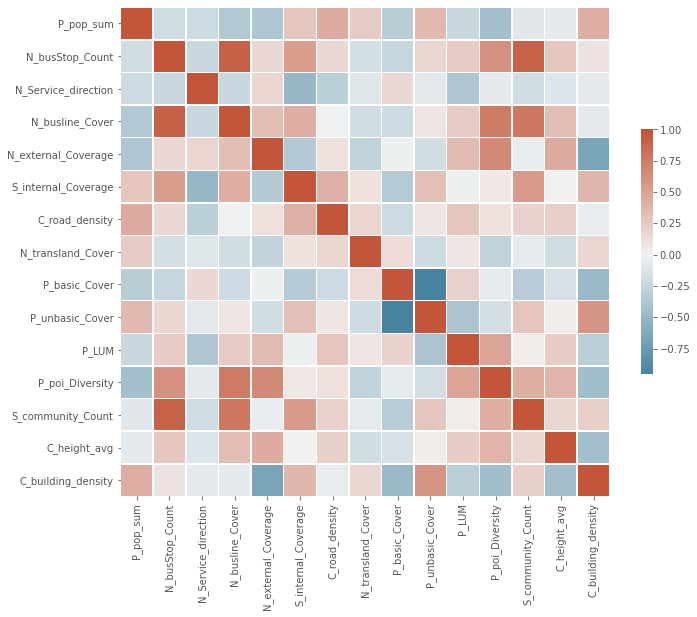

In [67]:
corrMatrix=fs_cor2.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot1=sns.heatmap(corrMatrix,  cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [68]:
plot1.figure.savefig("corr_fs.png",dpi=300)

In [69]:
fs_area.to_csv('fs_all_variables.csv',encoding='utf-8',index=False)

In [70]:
#分析
fs_PCA=fs_area.copy()

In [71]:
fs_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   25 non-null     int64   
 1   P_pop_sum            25 non-null     int64   
 2   road_length          25 non-null     float64 
 3   line_name            25 non-null     object  
 4   station_name         25 non-null     object  
 5   lng                  25 non-null     object  
 6   time                 25 non-null     int64   
 7   area                 25 non-null     float64 
 8   geometry             25 non-null     geometry
 9   lat                  25 non-null     object  
 10  lng84                25 non-null     object  
 11  lat84                25 non-null     object  
 12  N_busStop_Count      25 non-null     int64   
 13  N_Service_direction  25 non-null     int64   
 14  N_busline_Cover      25 non-null     float64 
 15  N_external_Covera

In [76]:
#PCA for Node
features_N = ['N_busStop_Count', 'N_Service_direction', 'N_busline_Cover','N_external_Coverage','N_transland_Cover'
           ]
# Separating out the features
x_N = fs_PCA.loc[:, features_N].values
# Standardizing the features
x_N =MinMaxScaler().fit_transform(x_N)#MinMaxScaler/StandardScaler

#PCA for Plcae
features_P = ['P_poi_Diversity', 'P_pop_sum', 'P_basic_Cover', 'P_unbasic_Cover','P_LUM'
           ]
# Separating out the features
x_P = fs_PCA.loc[:, features_P].values
# Standardizing the features
x_P = MaxAbsScaler().fit_transform(x_P)

#PCA for Settlement
features_S = ['S_community_Count','S_internal_Coverage'
           ]
# Separating out the features
x_S = fs_PCA.loc[:, features_S].values
# Standardizing the features
x_S = MinMaxScaler().fit_transform(x_S)

#PCA for Container
features_C = ['C_height_avg','C_building_density','C_road_density'
           ]
# Separating out the features
x_C = fs_PCA.loc[:, features_C].values
# Standardizing the features
x_C = MaxAbsScaler().fit_transform(x_C)

In [77]:
Node_arry=mcdm.weighting.critic(x_N)
Node_wgt=Node_arry.tolist()
Place_arry=mcdm.weighting.critic(x_P)
Place_wgt=Place_arry.tolist()
Settlement_arry=mcdm.weighting.critic(x_S)
Settlement_wgt=Settlement_arry.tolist()
Container_arry=mcdm.weighting.critic(x_C)
Container_wgt=Container_arry.tolist()

In [78]:
###测量correlation
fs_index=fs_area.copy()
fs_index= fs_index.drop(['lng84','lat84','geometry','line_name','station_name','lng','lat','area','road_length','time','id'],axis=1)

In [79]:
scaler = MinMaxScaler()
# fit and transform the data
gz_norm = pd.DataFrame(scaler.fit_transform(fs_index), columns=fs_index.columns)

In [80]:
#计算各维度index
gz_norm['Node_index']=gz_norm.N_busStop_Count*Node_wgt[0]+gz_norm.N_Service_direction*Node_wgt[1]+gz_norm.N_busline_Cover*Node_wgt[2]+gz_norm.N_external_Coverage*Node_wgt[3]+gz_norm.N_transland_Cover*Node_wgt[4]
gz_norm['Place_index']=gz_norm.P_poi_Diversity*Place_wgt[0]+gz_norm.P_pop_sum*Place_wgt[1]+gz_norm.P_basic_Cover*Node_wgt[2]+gz_norm.P_unbasic_Cover*Place_wgt[3]+gz_norm.P_LUM*Place_wgt[4]
gz_norm['Settlement_index']=gz_norm.S_community_Count*Settlement_wgt[0]+gz_norm.S_internal_Coverage*Settlement_wgt[1]
gz_norm['Container_index']=gz_norm.C_height_avg*Container_wgt[0]+gz_norm.C_building_density*Container_wgt[1]+gz_norm.C_road_density*Container_wgt[2]

In [81]:
gz_final=gz_norm[['Node_index','Place_index','Settlement_index','Container_index']]
gz_final['id']=gz_final.index.values+1

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
fs_final_area=pd.merge(fs_area,gz_final,on='id',how='left')
gz_temp=fs_final_area[['id','lng','Node_index','Place_index','Settlement_index','Container_index']]

In [83]:
fs_final_station=pd.merge(fs_station,gz_temp,on='id',how='left')

In [84]:
fs_final_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   25 non-null     int64   
 1   P_pop_sum            25 non-null     int64   
 2   road_length          25 non-null     float64 
 3   line_name            25 non-null     object  
 4   station_name         25 non-null     object  
 5   lng                  25 non-null     object  
 6   time                 25 non-null     int64   
 7   area                 25 non-null     float64 
 8   geometry             25 non-null     geometry
 9   lat                  25 non-null     object  
 10  lng84                25 non-null     object  
 11  lat84                25 non-null     object  
 12  N_busStop_Count      25 non-null     int64   
 13  N_Service_direction  25 non-null     int64   
 14  N_busline_Cover      25 non-null     float64 
 15  N_external_Covera

In [85]:
fs_final_area = fs_final_area.astype({"line_name":'string', "station_name":'string',"lat":'float64',"lng":'float64',"lat84":'float64',"lng84":'float64'})

In [86]:
fs_final_station.to_file("fs_station_withindex.shp")
fs_final_area.to_file("fs_area_withindex.shp")